# 2. Renaming and merging

Note: Half datasets, with separate files for east and west subplots have been merged manually in excel

In [1]:
%%time

import os
import math
from datetime import datetime as dt
import numpy as np
import pandas as pd
from copy import copy

# Dictionaries
import json
from pprint import pprint

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# To display df nicely in loops
from IPython.display import display 
# display(df1.head()) 
# display(df2.head())

# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',100)

# # For displaying max rows in series
# pd.options.display.max_rows = 10

Wall time: 1.06 s


In [2]:
# Prints the current working directory
os.getcwd()
# os.listdir()

'C:\\Users\\fahad\\MegaSync\\NMBU\\GitHub\\vPheno'

## Finding Username folder to make general path for multi PC use

In [3]:
username = str(os.getcwd()).split('\\')[2]
username

'fahad'

## Importing Data

In [4]:
main_path = r'./Data/'
path_complete = r'./Data/2,1. renamed_merged/'

path_yield = r'C:\\Users\\'+username+'\\MegaSync\\NMBU\\Master Thesis\\Data\\Feb2021'

export_path = './Data/2,2. renamed_merged/'
plots_export_path = './Data/2,2. plots/'

# Create export_path folder if not exists already
os.makedirs(export_path, exist_ok=True)
os.makedirs(plots_export_path, exist_ok=True)

os.listdir(main_path)

['1. complete_datasets',
 '2,1. renamed_merged',
 '2,2. plots',
 '2,2. renamed_merged',
 '3. merged data',
 '4. results_DM',
 '4. results_GY',
 'base_indices_columns.json',
 'spectral_indices_columns.json',
 'staur_weather_columns.json',
 'vollebekk_weather_columns.json',
 'yield_columns.json',
 'yield_df.json']

## Data Preparation
### Creating list of complete files

In [5]:
# Get the list of all files in directory tree at given path

files_with_address = []
files_list = []

for (dirpath, dirnames, filenames) in os.walk(path_complete):
    files_with_address += [os.path.join(dirpath, file) for file in filenames]
    files_list.extend(filenames)
    
print(len(files_with_address), 'files found in the directory')
# files_with_address
# files_list

67 files found in the directory


## Data Checking/control

### Check for duplicate filenames

In [6]:
print('Total number of files are :', len(files_list))

print('Number of unique file names are:', len(set(files_list)))

print('There is/are', len(files_list) - len(set(files_list)),'duplicate file name/names.')
if len(files_list) - len(set(files_list)) > 0:
    raise NameError

Total number of files are : 67
Number of unique file names are: 67
There is/are 0 duplicate file name/names.


In [7]:
# files_list

In [8]:
len(files_with_address)
# files_with_address

67

## Importing data files to Pandas

In [9]:
%%time

all_df = []
for data in files_with_address:
    file_name = os.path.splitext(os.path.basename(data))[0]

    # Replce all invalid characters in the name
    file_name = file_name.replace(" ", "_")
    file_name = file_name.replace("-", "_")
    file_name = file_name.replace(")", "")
    file_name = file_name.replace("(", "")
    df_name = file_name.replace(".", "")
    # Test: Check if the same date is already present in the current dict key
    if df_name in all_df:
        print(f'A file with the same name {df_name} has already been imported. \n Please check if there is duplication of data.')
        raise NameError
    df_new_name = df_name.split('_')[0] + '_' + df_name.split('_')[1]
    all_df.append(df_new_name)

    locals()[df_new_name] = pd.read_csv(data, index_col=False)
    print(df_new_name, '=====', locals()[df_new_name].shape)

Graminor_010720 ===== (400, 40)
Graminor_020719 ===== (600, 40)
Graminor_040720 ===== (800, 40)
Graminor_040820 ===== (793, 40)
Graminor_050719 ===== (597, 40)
Graminor_050819 ===== (600, 40)
Graminor_060619 ===== (600, 40)
Graminor_070720 ===== (800, 40)
Graminor_070819 ===== (600, 40)
Graminor_110619 ===== (600, 40)
Graminor_110719 ===== (300, 40)
Graminor_130720 ===== (800, 40)
Graminor_140820 ===== (800, 40)
Graminor_150719 ===== (600, 40)
Graminor_150819 ===== (600, 40)
Graminor_170720 ===== (400, 40)
Graminor_180620 ===== (400, 40)
Graminor_200720 ===== (400, 40)
Graminor_240620 ===== (757, 40)
Graminor_250719 ===== (600, 40)
Graminor_280619 ===== (600, 40)
Graminor_300720 ===== (787, 40)
Masbasis_010720 ===== (688, 43)
Masbasis_050719 ===== (528, 41)
Masbasis_060619 ===== (528, 41)
Masbasis_070819 ===== (528, 41)
Masbasis_070820 ===== (688, 43)
Masbasis_080720 ===== (688, 43)
Masbasis_120820 ===== (688, 43)
Masbasis_130720 ===== (688, 43)
Masbasis_140820 ===== (688, 43)
Masbasis

In [10]:
print(f'Total imported {len(all_df)}')

Total imported 67


# Standardizing the names

## Creating a dictionary with all dates for a certain field for a certain year

In [11]:
%%time

elements_to_strip = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_-()."

field_year_dict = {}

for df in all_df:
    
    # Getting date from the df name
    field_name = df.split('_')[0]
    date_ = df.split('_')[1]

    # Creating a dict with all dates for a certain field for a certain year
    dict_key = field_name+'_20'+date_[-2:]
    
    # If the Field name is present in dict then add the date to that key
    # Otherwise, create new key for current field and add the date to it
    if dict_key in field_year_dict:
        # Test: Check if the same date is already present in the current dict key
        if date_ in field_year_dict[dict_key]:
            print(f'Duplicate Data file Error: {date_} is already present in {dict_key}\n Current df {df}\n Conflict with {renamed_to_from[new_df_name]}')
            raise NameError
        field_year_dict[dict_key].append(date_)
    else:
        field_year_dict[dict_key] = [date_]
    
print('field_year_dict created.')

pprint(field_year_dict)

field_year_dict created.
{'Graminor_2019': ['020719',
                   '050719',
                   '050819',
                   '060619',
                   '070819',
                   '110619',
                   '110719',
                   '150719',
                   '150819',
                   '250719',
                   '280619'],
 'Graminor_2020': ['010720',
                   '040720',
                   '040820',
                   '070720',
                   '130720',
                   '140820',
                   '170720',
                   '180620',
                   '200720',
                   '240620',
                   '300720'],
 'Masbasis_2019': ['050719',
                   '060619',
                   '070819',
                   '150719',
                   '220719',
                   '260619',
                   '280619',
                   '290719'],
 'Masbasis_2020': ['010720',
                   '070820',
                   '080720',
               

## Test: Check if there are duplicate datasets/names in all_df

In [12]:

if len(all_df) > len(set(all_df)):
    duplicates = len(all_df) - len(set(all_df))
    if duplicates>1:
        verb, plural='are', 's'
    else:
        verb, plural='is', ''
    print(f'Error:\nThere {verb} {duplicates} duplicate name{plural} in the datasets out of total {len(all_df)}.\n \
    Make sure no dataset has been lost because of data being separated in east/west fields on the same date')
    # Printing the names of the duplicate datasets, if any
    find_duplicates=[]
    for i in all_df:
        if i not in find_duplicates:
            find_duplicates.append(i)
        else:
            print(f'Duplicate dataset named \'{i}\',\n')
    raise NameError
    
else:
    print('No duplicate dataset found')

No duplicate dataset found


## Arranging the dates in field_year_dict in ascending order

In [13]:
sorted_field_year_dict = {}
for key, dates_list in field_year_dict.items():
    # Converting the dates to a datetime date object and sorting them in list
    sorted_dated = sorted([
        dt.strptime(date, '%d%m%y').date()
        for date in dates_list])
    
    
#     sorted_dated = [
#         dt.strftime(date, '%d-%m-%Y')
#         for date in sorted_dated]
#     print(key, len(sorted_dated))
    
    
    sorted_field_year_dict[key] = sorted_dated

pprint(sorted_field_year_dict)

{'Graminor_2019': [datetime.date(2019, 6, 6),
                   datetime.date(2019, 6, 11),
                   datetime.date(2019, 6, 28),
                   datetime.date(2019, 7, 2),
                   datetime.date(2019, 7, 5),
                   datetime.date(2019, 7, 11),
                   datetime.date(2019, 7, 15),
                   datetime.date(2019, 7, 25),
                   datetime.date(2019, 8, 5),
                   datetime.date(2019, 8, 7),
                   datetime.date(2019, 8, 15)],
 'Graminor_2020': [datetime.date(2020, 6, 18),
                   datetime.date(2020, 6, 24),
                   datetime.date(2020, 7, 1),
                   datetime.date(2020, 7, 4),
                   datetime.date(2020, 7, 7),
                   datetime.date(2020, 7, 13),
                   datetime.date(2020, 7, 17),
                   datetime.date(2020, 7, 20),
                   datetime.date(2020, 7, 30),
                   datetime.date(2020, 8, 4),
                   da

## Summary of remaining data

In [14]:
for field, dates in sorted_field_year_dict.items():
    rows_df = []
    for date in dates:
        field_name = field.split('_')[0]+'_'+date.strftime('%d%m%y')
        temp_df = locals()[field_name].copy()
        rows_df.append(temp_df.shape[0])
    print(field.split('_')[0], date.year, 'Rows:', rows_df)

Graminor 2020 Rows: [400, 757, 400, 800, 800, 800, 400, 400, 787, 793, 800]
Graminor 2019 Rows: [600, 600, 600, 600, 597, 300, 600, 600, 600, 600, 600]
Masbasis 2020 Rows: [688, 688, 688, 688, 688, 688, 688, 688, 688, 688, 688, 688]
Masbasis 2019 Rows: [528, 528, 528, 528, 528, 528, 528, 528]
Robot 2020 Rows: [96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96]
Staur 2019 Rows: [1328, 1328, 1328, 1326, 1328]
Staur 2020 Rows: [1506, 1506, 1506, 1506, 1506, 1506]


# Importing Yield columns and Spectral Indices

In [15]:
a_file = open(main_path+"yield_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to dictionary
yield_cols = json.loads(output_str)
a_file.close()
print(yield_cols)

['Entry', 'CodeName', 'Block', 'Pedigree', 'Replicates', 'iBlock', 'Heading_Date', 'Maturity_Date', 'Days2Maturity', 'Line', 'Lodging', 'GrainYield', 'Days2Heading', 'Name']


In [16]:
a_file = open(main_path+"spectral_indices_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to dictionary
spectral_indices = json.loads(output_str)
a_file.close()
print(spectral_indices)

['NDVI', 'MTCI', 'DVI', 'GDVI', 'EXG', 'EXGR', 'RDVI', 'TDVI', 'GNDVI', 'NDRE', 'SCCI', 'EVI', 'TVI', 'VARI', 'GARI', 'GCI', 'GLI', 'NLI', 'MNLI', 'SAVI', 'GSAVI', 'OSAVI', 'GOSAVI', 'MSAVI2', 'MSR', 'GRVI', 'WDRVI', 'SR']


In [17]:
a_file = open(main_path+"base_indices_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to dictionary
base_indices = json.loads(output_str)
a_file.close()
print(base_indices)

['Blue', 'Green', 'Red', 'RedEdge', 'NIR']


# Visualisation

## Plots

In [18]:
# from matplotlib.backends.backend_pdf import PdfPages

# # Create plots folder if not exists already
# os.makedirs(plots_export_path, exist_ok=True)

# pdf = PdfPages(plots_export_path+'Plots_median.pdf')

# for col in base_indices+spectral_indices:
#     print(col)
#     fields = len(sorted_field_year_dict.keys())
#     rows = math.ceil(fields/2)
#     fig_size=(15,10)
#     n_plot = 0

#     if fields < 2:
#         columns = 1
#         fig, ax = plt.subplots(rows,columns, figsize=fig_size)
#         plots = [ax]
#     else:
#         columns = 2
#         fig, ax = plt.subplots(rows,columns, figsize=fig_size)
#         plots = ax.flatten()
#         # Remove the last fig if the number of fields is an odd number
#         if not (fields % 2) == 0:
#             fig.delaxes(ax[rows-1,1])

#     for field_sample, dates in sorted_field_year_dict.items():

#         # Adding required data to a temp dataframe
#         temp_df = pd.DataFrame()
#         for date in dates:
#             date_str = date.strftime('%d%m%y')
#             field_df = field_sample[:-5]+'_'+date_str
#             col_name = date.strftime('%d-%b')+'_'+col
#             temp_df[col_name] = locals()[field_df][col]

#         # Adding field plot to the subplots

#         ax_n = plots[n_plot]
#         x_labels = [date[:-(len(col)+1)] for date in temp_df.columns.tolist()]
#         temp_df.boxplot(ax=ax_n)

#         ax_n.set_xticklabels(x_labels, rotation=45)
#         ax_n.set_title(field_sample)
        
#         # Printing the band/index name in plot of the fiels_sample for reference
#         text = col
#         ax_n.text(0.01, 0.97, text, ha='left', va='top', weight='bold', color='blue', transform=ax_n.transAxes)
        
#         n_plot += 1

#     plt.tight_layout()

#     # Create plots folder if not exists already
#     os.makedirs(plots_export_path, exist_ok=True)

# #     plt.savefig(plots_export_path+col+'.png',dpi=500, bbox_inches='tight')
#     plt.savefig(plots_export_path+col+'.pdf',dpi=500, bbox_inches='tight')
#     plt.savefig(plots_export_path+col+'.jpg',dpi=150, bbox_inches='tight')

#     pdf.savefig(fig)

#     plt.show()
# pdf.close()

In [19]:
# from matplotlib.backends.backend_pdf import PdfPages

# # Create plots folder if not exists already
# os.makedirs(plots_export_path, exist_ok=True)

# pdf = PdfPages(plots_export_path+'Plots_median.pdf')

# for d_type in data_agg_list:
#     for col in base_indices+spectral_indices:
#         print(col)
#         fields = len(sorted_field_year_dict_yield.keys())
#         rows = math.ceil(fields/2)
#         fig_size=(15,10)
#         n_plot = 0
        
#         if fields < 2:
#             columns = 1
#             fig, ax = plt.subplots(rows,columns, figsize=fig_size)
#             plots = [ax]
#         else:
#             columns = 2
#             fig, ax = plt.subplots(rows,columns, figsize=fig_size)
#             plots = ax.flatten()
#             # Remove the last fig if the number of fields is an odd number
#             if not (fields % 2) == 0:
#                 fig.delaxes(ax[rows-1,1])
            
#         for field_sample, dates in sorted_field_year_dict_yield.items():
            
#             # Adding required data to a temp dataframe
#             temp_df = pd.DataFrame()
#             for date in dates:
#                 date_str = date.strftime('%d%m%y')
#                 field_df = field_sample[:-5]+'_'+date_str+d_type
#                 col_name = date.strftime('%d-%b')+'_'+col
#                 temp_df[col_name] = locals()[field_df][col]
            
#             # Adding field plot to the subplots
            
#             ax_n = plots[n_plot]
#             x_labels = [date[:-(len(col)+1)] for date in temp_df.columns.tolist()]
#             temp_df.boxplot(ax=ax_n)

#             ax_n.set_xticklabels(x_labels, rotation=45)
#             data_type = d_type.split('_')[2]
#             ax_n.set_title(field_sample+'_'+col)
            
# #             # Printing the grain yield in plot of the fiels_sample for reference
# #             text = "Grain Yield"
# #             ax_n.text(0.85, 1.05, text, ha='center', va='top', weight='bold', color='blue', transform=ax_n.transAxes)
#             n_plot += 1
    
#         plt.tight_layout()

#         # Create plots folder if not exists already
#         os.makedirs(plots_export_path, exist_ok=True)
        
# #         plt.savefig(plots_export_path+col+'.png',dpi=500, bbox_inches='tight')
# #         plt.savefig(plots_export_path+col+'.pdf',dpi=500, bbox_inches='tight')
#         plt.savefig(plots_export_path+col+'.jpg',dpi=150, bbox_inches='tight')

#         pdf.savefig(fig)

#         plt.show()
# pdf.close()

## Summary of remaining data

In [20]:

for field, dates in sorted_field_year_dict.items():
    rows_df = []
    rows_df_yield = []
    rows_df_agg = []
    # Grain yield date is not available for Masbasis 2021
    # So skipping it for now
    if field == 'Masbasis_2021':
        continue
    for date in dates:

        field_agg = field[:-5]+'_'+date.strftime('%d%m%y')
        temp_df_agg = locals()[field_agg].copy()
        rows_df_agg.append(temp_df_agg.shape[0])
#         print(field_name, temp_df.shape)

        field_name = field.split('_')[0]+'_'+date.strftime('%d%m%y')
        temp_df = locals()[field_name].copy()
        rows_df.append(temp_df.shape[0])
#         print(field_name, temp_df.shape)


#         print(field_agg, field_name, field_name_yield)
    print(field.split('_')[0], date.year, ' Import Rows:', rows_df_agg)
    print(field.split('_')[0], date.year, '        Rows:', rows_df)
# sorted_field_year_dict
#         print(field_name)

Graminor 2020  Import Rows: [400, 757, 400, 800, 800, 800, 400, 400, 787, 793, 800]
Graminor 2020         Rows: [400, 757, 400, 800, 800, 800, 400, 400, 787, 793, 800]
Graminor 2019  Import Rows: [600, 600, 600, 600, 597, 300, 600, 600, 600, 600, 600]
Graminor 2019         Rows: [600, 600, 600, 600, 597, 300, 600, 600, 600, 600, 600]
Masbasis 2020  Import Rows: [688, 688, 688, 688, 688, 688, 688, 688, 688, 688, 688, 688]
Masbasis 2020         Rows: [688, 688, 688, 688, 688, 688, 688, 688, 688, 688, 688, 688]
Masbasis 2019  Import Rows: [528, 528, 528, 528, 528, 528, 528, 528]
Masbasis 2019         Rows: [528, 528, 528, 528, 528, 528, 528, 528]
Robot 2020  Import Rows: [96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96]
Robot 2020         Rows: [96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96]
Staur 2019  Import Rows: [1328, 1328, 1328, 1326, 1328]
Staur 2019         Rows: [1328, 1328, 1328, 1326, 1328]
Staur 2020  Import Rows: [1506, 1506, 1506, 1506, 1506, 1506]
Staur 2020

# ToDo: Identify df which are outliers

Identify the datasets from the plots above which do not aligh with the trends of their neighbouring datasets.

## Drop outlier datasets

**OLD**
Graminor 2019	7 Aug Green  
Masbasis 2019	15-Jul BlueGreenRedRedEdgeNIR  
Masbasis 2020	13 jul BlueGreenRedRedEdgeNIR  
Robot 2020	29Jun BlueGreenRedRedEdgeNIR  

In [21]:
outliers = {
    'Graminor_2019':'',
    'Masbasis_2019':'150719',
    'Masbasis_2020':'130720',
    'Robot_2020':'290620'
           }
outliers

{'Graminor_2019': '',
 'Masbasis_2019': '150719',
 'Masbasis_2020': '130720',
 'Robot_2020': '290620'}

## Update field_year_dict and sorted_field_year_dict

In [22]:
sorted_field_year_dict.keys()
# field_year_dict

dict_keys(['Graminor_2020', 'Graminor_2019', 'Masbasis_2020', 'Masbasis_2019', 'Robot_2020', 'Staur_2019', 'Staur_2020'])

# Merge data at plots

## Merging datasets on Plot_ID 

In [23]:
### TODO: What if the dataset from which the yield columns are being taken from does not have all the entries
### maybe because a few plot_id were dropped in pre processing since they were duplicated for some reason

In [24]:
list_agg_df = []
# In this loop we select which aggregated data type we will use for further processing.
# It is defined in the list data_agg_list
for field_sample, dates in sorted_field_year_dict.items():

    # Adding required data to a temp dataframe
    temp_df_all = field_sample+'_all'
    locals()[temp_df_all] = pd.DataFrame()
    # Problem: If the first dataset related to the first in the dates list has less number of rows than the others,
    # The following code will keep those rows/entries and find entries with same Plot_ID in other dates
    # Resulting in, if the remaining datasets had more subplots, they would be left out
    # So we need to sort the dates list with descending number of rows in the respective datasets

    # List of dates df related to current field
    temp_list_df = [field_sample[:-5]+'_'+date.strftime('%d%m%y') for date in dates]

    # List of number of rows in all the datasets of the current field
    list_entries = []
    # Populating the list_entries
    for df in temp_list_df:
        temp_df = locals()[df].copy()
        list_entries.append(temp_df.shape[0])

    # Sorting the dates list based on the reverse sorted list_entries list
    sorted_dates = list(zip(*sorted(zip(list_entries, dates), reverse=True)))[1]

    for date in sorted_dates:

        date_str = date.strftime('%d%m%y')
        field_df = field_sample[:-5]+'_'+date_str
#         print(field_df)
        temp_df = locals()[field_df].copy()
#         print(date, locals()[temp_df_all].shape)

        # Adding date as a suffix to all column headings except Plot_ID
        columns_temp = ['Plot_ID']+[x+'_'+date_str for x in temp_df.columns[1:]]

        # Making a temp list of yield columns since all entries from yield cols are not present in every df
        temp_yield_cols = [x for x in temp_df.columns if x in yield_cols]

        # Removing the date suffix from the yield columns
        for ycol in temp_yield_cols:
            temp_yield_col = ycol+'_'+date_str
            if temp_yield_col in columns_temp:
                index_yield = columns_temp.index(temp_yield_col)
                if columns_temp[index_yield] == temp_yield_col:
                    columns_temp.remove(temp_yield_col)
                    columns_temp.insert(index_yield, ycol)

        temp_df.columns = columns_temp

        # For first dataset, keep all columns
        if locals()[temp_df_all].shape[1] < len(base_indices):
            locals()[temp_df_all] = temp_df.copy()
#             display(temp_df)

        # For the remaining, delete yield columns
        else:
            # Dropping grain yield columns to avoid duplication
            for col in temp_yield_cols:
                temp_df.drop(columns=[col], inplace=True)



            # Merging dataframes
#             locals()[temp_df_all] = pd.concat([locals()[temp_df_all].set_index('Plot_ID'),temp_df.set_index('Plot_ID')], axis=1, join='inner').reset_index()
#             print(temp_df_all, date, field_df, locals()[temp_df_all].shape, temp_df.shape)
            # The following does not handle duplicate values in the reference column. It will not merge them, rather keep both.
            # So the duplicates should have be dealt with before this step
            locals()[temp_df_all] = locals()[temp_df_all].merge(temp_df, on='Plot_ID', how='left', suffixes=('', date_str))

#             locals()[temp_df_all] = locals()[temp_df_all].join(temp_df, on='Plot_ID', lsuffix='', rsuffix='_right')

#             display(locals()[temp_df_all])


    list_agg_df.append(temp_df_all)  
    print(temp_df_all, locals()[temp_df_all].shape)
    display(locals()[temp_df_all].head())


Graminor_2020_all (800, 370)


,Plot_ID,Blue_140820,Green_140820,NIR_140820,Red_140820,RedEdge_140820,GrainYield,Block,iBlock,Entry,Name,Pedigree,NDVI_140820,MTCI_140820,DVI_140820,GDVI_140820,EXG_140820,EXGR_140820,RDVI_140820,TDVI_140820,GNDVI_140820,NDRE_140820,SCCI_140820,EVI_140820,TVI_140820,VARI_140820,GARI_140820,GCI_140820,GLI_140820,NLI_140820,MNLI_140820,SAVI_140820,GSAVI_140820,OSAVI_140820,GOSAVI_140820,MSAVI2_140820,MSR_140820,GRVI_140820,WDRVI_140820,SR_140820,Blue_130720,Green_130720,Red_130720,RedEdge_130720,NIR_130720,NDVI_130720,MTCI_130720,DVI_130720,GDVI_130720,EXG_130720,...,EVI_010720,TVI_010720,VARI_010720,GARI_010720,GCI_010720,GLI_010720,NLI_010720,MNLI_010720,SAVI_010720,GSAVI_010720,OSAVI_010720,GOSAVI_010720,MSAVI2_010720,MSR_010720,GRVI_010720,WDRVI_010720,SR_010720,Blue_180620,Green_180620,NIR_180620,Red_180620,RedEdge_180620,NDVI_180620,MTCI_180620,DVI_180620,GDVI_180620,EXG_180620,EXGR_180620,RDVI_180620,TDVI_180620,GNDVI_180620,NDRE_180620,SCCI_180620,EVI_180620,TVI_180620,VARI_180620,GARI_180620,GCI_180620,GLI_180620,NLI_180620,MNLI_180620,SAVI_180620,GSAVI_180620,OSAVI_180620,GOSAVI_180620,MSAVI2_180620,MSR_180620,GRVI_180620,WDRVI_180620,SR_180620
0,101,0.055459,0.109661,0.328792,0.167141,0.202937,654.708159,1,1,1,Zebra,Ralle/Dragon,0.325954,3.515836,0.161651,0.219131,-0.003278,-0.127614,0.229545,0.275391,0.499783,0.236689,0.726144,-4.490722,7.399860,-0.259687,0.046587,1.998261,-0.007417,-0.214488,-0.114229,0.243467,0.350254,0.246445,0.366163,1.054596,0.402553,2.998261,-0.671241,1.967155,0.019435,0.056165,0.032753,0.134172,0.420785,0.855566,2.826056,0.388032,0.364620,0.060143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,102,0.041715,0.089389,0.308297,0.136032,0.180766,709.595446,1,1,19,GN18666,GN04528/GN03509,0.387696,2.850898,0.172265,0.218908,0.001032,-0.100024,0.258431,0.302208,0.550454,0.260766,0.672605,2.402659,8.470183,-0.253899,0.104955,2.448928,0.002894,-0.177363,-0.084091,0.273631,0.365787,0.285051,0.392529,1.060884,0.505441,3.448928,-0.630476,2.266354,0.017639,0.048449,0.026945,0.122271,0.425468,0.880883,3.180647,0.398523,0.377019,0.052314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,103,0.042659,0.088920,0.285287,0.127826,0.168980,707.100569,1,1,11,GN15590,Demonstrant/SW51114,0.381158,2.826091,0.157461,0.196367,0.007355,-0.082681,0.244985,0.280463,0.524756,0.256031,0.671720,1.984207,7.891415,-0.223486,0.099391,2.208364,0.021115,-0.221960,-0.098216,0.258666,0.336935,0.274747,0.367586,1.021253,0.493935,3.208364,-0.635077,2.231841,0.017086,0.051668,0.029869,0.125352,0.420288,0.867294,3.088887,0.390418,0.368619,0.056382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,104,0.045332,0.093895,0.302631,0.134797,0.178754,724.958634,1,1,5,Mirakel,SW38337/NK98533//NK98535,0.383683,2.818120,0.167834,0.208736,0.007661,-0.087160,0.253762,0.295385,0.526411,0.257334,0.670693,2.727140,8.433950,-0.223070,0.103252,2.223074,0.020822,-0.190879,-0.089233,0.268555,0.349241,0.280927,0.375069,1.049790,0.498361,3.223074,-0.633308,2.245085,0.017941,0.054604,0.029667,0.130905,0.420737,0.868263,2.862901,0.391070,0.366134,0.061599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,0.035552,0.076771,0.278196,0.113046,0.157486,740.978368,1,1,24,GN18751,QUARNA/GN03531,0.422118,2.716224,0.165150,0.201425,0.004943,-0.076550,0.264032,0.298132,0.567448,0.277060,0.656356,1.238829,8.458011,-0.235149,0.143180,2.623727,0.016

Graminor_2019_all (600, 370)


,Plot_ID,Blue_150819,Green_150819,Red_150819,RedEdge_150819,NIR_150819,GrainYield,Block,iBlock,Entry,Name,Pedigree,NDVI_150819,MTCI_150819,DVI_150819,GDVI_150819,EXG_150819,EXGR_150819,RDVI_150819,TDVI_150819,GNDVI_150819,NDRE_150819,SCCI_150819,EVI_150819,TVI_150819,VARI_150819,GARI_150819,GCI_150819,GLI_150819,NLI_150819,MNLI_150819,SAVI_150819,GSAVI_150819,OSAVI_150819,GOSAVI_150819,MSAVI2_150819,MSR_150819,GRVI_150819,WDRVI_150819,SR_150819,Blue_070819,Green_070819,NIR_070819,Red_070819,RedEdge_070819,NDVI_070819,MTCI_070819,DVI_070819,GDVI_070819,EXG_070819,...,EVI_050719,TVI_050719,VARI_050719,GARI_050719,GCI_050719,GLI_050719,NLI_050719,MNLI_050719,SAVI_050719,GSAVI_050719,OSAVI_050719,GOSAVI_050719,MSAVI2_050719,MSR_050719,GRVI_050719,WDRVI_050719,SR_050719,Blue_110719,Green_110719,NIR_110719,Red_110719,RedEdge_110719,NDVI_110719,MTCI_110719,DVI_110719,GDVI_110719,EXG_110719,EXGR_110719,RDVI_110719,TDVI_110719,GNDVI_110719,NDRE_110719,SCCI_110719,EVI_110719,TVI_110719,VARI_110719,GARI_110719,GCI_110719,GLI_110719,NLI_110719,MNLI_110719,SAVI_110719,GSAVI_110719,OSAVI_110719,GOSAVI_110719,MSAVI2_110719,MSR_110719,GRVI_110719,WDRVI_110719,SR_110719
0,101,0.028785,0.058441,0.117516,0.140037,0.219810,499.624440,1,1,1,Zebra,Ralle/Dragon,0.303250,3.542136,0.102294,0.161369,-0.029419,-0.135500,0.176127,0.188044,0.579940,0.221686,0.731033,0.855803,3.774674,-0.401399,0.024532,2.761220,-0.111780,-0.417284,-0.155894,0.183252,0.311022,0.205689,0.368211,0.879676,0.367652,3.761220,-0.684853,1.870472,0.028076,0.024914,0.261002,0.042590,0.155006,0.719425,0.942886,0.218412,0.236087,-0.020837,...,0.613283,16.716301,0.487725,0.760389,7.356185,0.396205,0.666443,0.160915,0.500898,0.457195,0.581444,0.522259,1.283984,3.203754,8.356185,0.277236,17.671545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,102,0.025709,0.051825,0.102399,0.122849,0.201019,515.532751,1,1,11,GN14547,SW45126/NK01533,0.325028,3.822563,0.098619,0.149194,-0.024459,-0.115994,0.179037,0.184507,0.590065,0.241364,0.742593,0.626071,3.894176,-0.393533,0.049114,2.878825,-0.105539,-0.434086,-0.144656,0.184125,0.297261,0.212809,0.361382,0.859646,0.401102,3.878825,-0.671809,1.963087,0.025488,0.023212,0.251316,0.042701,0.145268,0.709534,1.033950,0.208615,0.228105,-0.021766,...,0.699103,19.906239,0.575129,0.755242,6.853456,0.465505,0.737698,0.223140,0.556769,0.496448,0.619694,0.541915,1.414317,3.472025,7.853456,0.333311,19.999006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,103,0.024099,0.047830,0.084905,0.113178,0.184771,529.501025,1,1,13,Tarrafal,NaN,0.370319,2.532189,0.099866,0.136941,-0.013344,-0.084380,0.192308,0.190392,0.588738,0.240286,0.648862,0.504781,4.508981,-0.341276,0.099921,2.863084,-0.065198,-0.426430,-0.123007,0.194627,0.280387,0.232422,0.348805,0.850718,0.475200,3.863084,-0.642547,2.176214,0.022721,0.022812,0.247284,0.035163,0.141320,0.751014,0.998172,0.212121,0.224472,-0.012260,...,0.712242,20.401982,0.547252,0.769166,7.570712,0.449395,0.751494,0.236541,0.567648,0.512978,0.627061,0.556994,1.440607,3.546271,8.570712,0.347867,20.668579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,104,0.022502,0.044899,0.085384,0.108823,0.182668,544.503985,1,1,14,GN12760,NK02529/NK01533//NK01568,0.362930,3.150474,0.097284,0.137769,-0.018088,-0.092726,0.187902,0.185513,0.605400,0.253334,0.698026,0.484867,4.217642,-0.375622,0.092293,3.068425,-0.091498,-0.438027,-0.126100,0.189995,0.284034,0.227272,0.355472,0.844311,0.462659,4.068425,-0.647532,2.139371,0.020872,0.019353,0.227585,0.038502,0.127392,0.710604,1.127151,0.189083,0.208232,-0.020669,...,0.707047,20.538305,0.578383,0.797089,8.470096,0.451724,0.781208,0.243975,0.574042,0.522680,0.634579,0.568534,1.452706,3.877640,9.470096,0.408133,23.791370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Masbasis_2020_all (688, 406)


,Plot_ID,Blue_140820,Green_140820,NIR_140820,Red_140820,RedEdge_140820,GrainYield,Replicates,Block,Name,Line,Maturity_Date,Days2Heading,Days2Maturity,Lodging,NDVI_140820,MTCI_140820,DVI_140820,GDVI_140820,EXG_140820,EXGR_140820,RDVI_140820,TDVI_140820,GNDVI_140820,NDRE_140820,SCCI_140820,EVI_140820,TVI_140820,VARI_140820,GARI_140820,GCI_140820,GLI_140820,NLI_140820,MNLI_140820,SAVI_140820,GSAVI_140820,OSAVI_140820,GOSAVI_140820,MSAVI2_140820,MSR_140820,GRVI_140820,WDRVI_140820,SR_140820,Blue_120820,Green_120820,NIR_120820,Red_120820,RedEdge_120820,NDVI_120820,MTCI_120820,...,EVI_240620,TVI_240620,VARI_240620,GARI_240620,GCI_240620,GLI_240620,NLI_240620,MNLI_240620,SAVI_240620,GSAVI_240620,OSAVI_240620,GOSAVI_240620,MSAVI2_240620,MSR_240620,GRVI_240620,WDRVI_240620,SR_240620,Blue_180620,Green_180620,Red_180620,RedEdge_180620,NIR_180620,NDVI_180620,MTCI_180620,DVI_180620,GDVI_180620,EXG_180620,EXGR_180620,RDVI_180620,TDVI_180620,GNDVI_180620,NDRE_180620,SCCI_180620,EVI_180620,TVI_180620,VARI_180620,GARI_180620,GCI_180620,GLI_180620,NLI_180620,MNLI_180620,SAVI_180620,GSAVI_180620,OSAVI_180620,GOSAVI_180620,MSAVI2_180620,MSR_180620,GRVI_180620,WDRVI_180620,SR_180620
0,1378,0.044575,0.084105,0.267094,0.134233,0.164202,740.000000,1.0,36.0,GN04528,53.0,2020-08-12,67,89.0,0.0,0.331053,3.433267,0.132861,0.182989,-0.010598,-0.114419,0.209724,0.237256,0.521039,0.238564,0.720620,2.607555,5.966537,-0.288483,0.060700,2.175707,-0.030539,-0.305945,-0.133708,0.221109,0.322466,0.236690,0.357959,0.966111,0.410594,3.175707,-0.668088,1.989776,0.042142,0.081473,0.281642,0.133775,0.170552,0.355948,3.020637,...,0.812752,24.336192,0.599426,0.847487,10.654493,0.403425,0.839262,0.332701,0.638507,0.592076,0.674838,0.617912,1.618847,4.306146,11.654493,0.475825,28.155189,0.020137,0.051170,0.018309,0.144532,0.560646,0.936753,3.296639,0.542338,0.509476,0.063894,0.089432,0.712767,0.891526,0.832727,0.590083,0.629924,1.043145,33.854711,0.666000,0.842087,9.956531,0.453840,0.889917,0.533276,0.753976,0.687357,0.733925,0.660100,1.920556,4.533712,10.956531,0.507656,30.621965
1,1379,0.040442,0.078330,0.270643,0.121406,0.161541,729.333333,1.0,36.0,GN12625,1530.0,2020-08-16,68,93.0,0.0,0.380659,2.718355,0.149237,0.192313,-0.005188,-0.096827,0.238345,0.268586,0.551083,0.252443,0.663173,1.561774,7.231181,-0.270419,0.112359,2.455165,-0.016290,-0.247406,-0.103991,0.250945,0.339786,0.270333,0.377845,0.997763,0.493064,3.455165,-0.635425,2.229240,0.046883,0.092634,0.320475,0.141426,0.196621,0.387635,2.243933,...,0.789705,24.087155,0.616093,0.851566,11.331991,0.437422,0.854417,0.329814,0.637485,0.591933,0.676983,0.620765,1.614358,4.637452,12.331991,0.521312,31.780864,0.015964,0.044031,0.014747,0.134165,0.557917,0.948496,3.548503,0.543170,0.513886,0.057352,0.080737,0.717771,0.896462,0.853704,0.612287,0.645535,1.006089,33.761570,0.683965,0.860093,11.670878,0.482869,0.909531,0.538470,0.759562,0.699514,0.741362,0.674436,1.934592,5.150758,12.670878,0.581868,37.831823
2,1380,0.039090,0.070755,0.226598,0.106678,0.134150,534.666667,1.0,36.0,DH20070,93.0,2020-08-10,65,87.0,80.0,0.359822,3.365078,0.119920,0.155843,-0.004258,-0.082852,0.207725,0.221749,0.524102,0.256266,0.712201,1.021959,5.758273,-0.259667,0.099316,2.202580,-0.014822,-0.350144,-0.126130,0.215871,0.293176,0.243109,0.340750,0.916442,0.457440,3.202580,-0.649603,2.124132,0.055284,0.105973,0.340463,0.175952,0.214336,0.318563,3.285934,...,0.707451,20.343275,0.511880,0.846968,11.314159,0.354981,0.795067,0.247552,0.577100,0.542695,0.638102,0.593585,1.458710,4.054473,12.314159,0.437376,25.547698,0.016282,0.040706,0.015884,0.118876,0.506239,0.939156,3.761123,0.490355,0.465533,0.049245,0.067713,0.678616,0.837043,0.851152,0.619668,0.659814,0.951171,30.414170,0.615803,0.853445,11.436541,0.433583,0.883275,0.466989,0.719612,0.666988,0.718866,0.658514,1.834133,4.645421,12.436541,0.522340,31.870782
3,1381,0.037766,0.077348,0.272632,0.108060,0.164126,745.333333,1.0,36.0,GONDO,30.0,2020-08-18,72,95.0,0.0,0.432297,1.935357,0.164572,0.195285

Masbasis_2019_all (528, 272)


,Plot_ID,Blue_070819,Green_070819,Red_070819,RedEdge_070819,NIR_070819,GrainYield,Replicates,Block,Name,Line,Days2Heading,Days2Maturity,NDVI_070819,MTCI_070819,DVI_070819,GDVI_070819,EXG_070819,EXGR_070819,RDVI_070819,TDVI_070819,GNDVI_070819,NDRE_070819,SCCI_070819,EVI_070819,TVI_070819,VARI_070819,GARI_070819,GCI_070819,GLI_070819,NLI_070819,MNLI_070819,SAVI_070819,GSAVI_070819,OSAVI_070819,GOSAVI_070819,MSAVI2_070819,MSR_070819,GRVI_070819,WDRVI_070819,SR_070819,Blue_290719,Green_290719,NIR_290719,Red_290719,RedEdge_290719,NDVI_290719,MTCI_290719,DVI_290719,GDVI_290719,...,EVI_260619,TVI_260619,VARI_260619,GARI_260619,GCI_260619,GLI_260619,NLI_260619,MNLI_260619,SAVI_260619,GSAVI_260619,OSAVI_260619,GOSAVI_260619,MSAVI2_260619,MSR_260619,GRVI_260619,WDRVI_260619,SR_260619,Blue_060619,Green_060619,NIR_060619,Red_060619,RedEdge_060619,NDVI_060619,MTCI_060619,DVI_060619,GDVI_060619,EXG_060619,EXGR_060619,RDVI_060619,TDVI_060619,GNDVI_060619,NDRE_060619,SCCI_060619,EVI_060619,TVI_060619,VARI_060619,GARI_060619,GCI_060619,GLI_060619,NLI_060619,MNLI_060619,SAVI_060619,GSAVI_060619,OSAVI_060619,GOSAVI_060619,MSAVI2_060619,MSR_060619,GRVI_060619,WDRVI_060619,SR_060619
0,1101,0.027451,0.067744,0.104684,0.170411,0.294232,522.666667,1,1,GN12687,1574,66,107,0.475159,1.883845,0.189548,0.226488,0.003354,-0.075459,0.300109,0.341973,0.625698,0.266485,0.560834,1.029598,9.895320,-0.254796,0.192980,3.343281,0.012532,-0.094696,-0.039301,0.316295,0.394131,0.339136,0.433905,1.086759,0.676507,4.343281,-0.561198,2.810676,0.020762,0.057749,0.318968,0.048628,0.146685,0.735427,1.756966,0.270340,0.261219,...,1.546800,59.996432,0.669624,0.750191,6.637532,0.576827,0.924008,0.921928,0.930313,0.793702,0.799634,0.671296,2.404121,4.089278,7.637532,0.442909,25.900747,0.034281,0.097474,0.648497,0.049302,0.209345,0.858692,2.743962,0.599194,0.551023,0.111364,0.139814,0.717303,0.912655,0.738666,0.511926,0.596170,1.367309,37.878526,0.428210,0.681118,5.653036,0.399825,0.790136,0.574180,0.750369,0.663366,0.698525,0.608213,1.949638,2.626769,6.653036,0.136198,13.153452
1,1102,0.022541,0.062822,0.073401,0.151996,0.281686,388.000000,1,1,Avocet YrA,28,69,110,0.586577,1.650088,0.208286,0.218864,0.029703,-0.010235,0.349536,0.386703,0.635293,0.299043,0.509811,0.774612,12.074006,-0.093051,0.307220,3.483856,0.134047,0.038930,0.013665,0.365376,0.388742,0.404370,0.433816,1.122394,0.958994,4.483856,-0.445331,3.837657,0.018017,0.050840,0.296625,0.034896,0.125367,0.789481,1.892965,0.261729,0.245785,...,1.540846,55.201438,0.657218,0.687791,5.050801,0.585306,0.896079,0.844112,0.887120,0.726191,0.774477,0.621023,2.295770,3.516175,6.050801,0.342015,20.395834,0.037745,0.102931,0.574011,0.058058,0.204256,0.816292,2.529140,0.515953,0.471079,0.110060,0.131711,0.648975,0.821496,0.695893,0.475101,0.582023,1.368460,32.752102,0.364101,0.613580,4.576631,0.364843,0.700382,0.458732,0.683642,0.600385,0.651399,0.562858,1.799319,2.144339,5.576631,-0.005689,9.886867
2,1103,0.023021,0.055790,0.088891,0.149933,0.276584,541.333333,1,1,GN08557,1313,70,108,0.513560,2.074809,0.187693,0.220794,-0.000332,-0.068990,0.310470,0.345145,0.664295,0.296942,0.578204,0.822378,9.937556,-0.272079,0.244887,3.957614,-0.001487,-0.074926,-0.027936,0.325301,0.397888,0.357188,0.448428,1.075993,0.763946,4.957614,-0.525378,3.111505,0.019105,0.052469,0.312099,0.039182,0.132499,0.776921,1.924616,0.272918,0.259630,...,1.621597,64.458701,0.719977,0.733877,5.837848,0.607071,0.929614,0.963540,0.949899,0.786800,0.807187,0.656586,2.469955,4.137602,6.837848,0.450473,26.394959,0.032565,0.106970,0.787919,0.039555,0.236050,0.904396,2.808558,0.748364,0.680949,0.141820,0.193413,0.822689,1.042091,0.760931,0.538950,0.595923,1.432165,47.598450,0.591567,0.737854,6.365782,0.495771,0.880204,0.751391,0.845626,0.732261,0.757857,0.645517,2.173337,3.463134,7.365782,0.331541,19.919561
3,1104,0.028770,0.069885,0.096600,0.175366,0.315173,572.000000,1,1,GN08541,1311,69,109,0.530807,1.774976,0.218572,0.245288,0.014399,-0.050957,0.340617,0.393009,0.63701

Robot_2020_all (96, 471)


,Plot_ID,Blue_120820,Green_120820,Red_120820,RedEdge_120820,NIR_120820,GrainYield,Block,Name,CodeName,Heading_Date,Maturity_Date,Days2Heading,Days2Maturity,NDVI_120820,MTCI_120820,DVI_120820,GDVI_120820,EXG_120820,EXGR_120820,RDVI_120820,TDVI_120820,GNDVI_120820,NDRE_120820,SCCI_120820,EVI_120820,TVI_120820,VARI_120820,GARI_120820,GCI_120820,GLI_120820,NLI_120820,MNLI_120820,SAVI_120820,GSAVI_120820,OSAVI_120820,GOSAVI_120820,MSAVI2_120820,MSR_120820,GRVI_120820,WDRVI_120820,SR_120820,Blue_040820,Green_040820,NIR_040820,Red_040820,RedEdge_040820,NDVI_040820,MTCI_040820,DVI_040820,...,EVI_230620,TVI_230620,VARI_230620,GARI_230620,GCI_230620,GLI_230620,NLI_230620,MNLI_230620,SAVI_230620,GSAVI_230620,OSAVI_230620,GOSAVI_230620,MSAVI2_230620,MSR_230620,GRVI_230620,WDRVI_230620,SR_230620,Blue_180620,Green_180620,NIR_180620,Red_180620,RedEdge_180620,NDVI_180620,MTCI_180620,DVI_180620,GDVI_180620,EXG_180620,EXGR_180620,RDVI_180620,TDVI_180620,GNDVI_180620,NDRE_180620,SCCI_180620,EVI_180620,TVI_180620,VARI_180620,GARI_180620,GCI_180620,GLI_180620,NLI_180620,MNLI_180620,SAVI_180620,GSAVI_180620,OSAVI_180620,GOSAVI_180620,MSAVI2_180620,MSR_180620,GRVI_180620,WDRVI_180620,SR_180620
0,1101,0.023059,0.043694,0.092061,0.134482,0.271711,453.658537,1,Avle,NaN,2020-06-21,2020-08-07,62,109,0.493852,3.234990,0.179650,0.228017,-0.027732,-0.112924,0.297860,0.330230,0.722935,0.337843,0.684098,0.821965,8.844282,-0.429183,0.255859,5.218511,-0.136944,-0.109920,-0.041076,0.311974,0.419455,0.342992,0.479627,1.057378,0.717968,6.218511,-0.544233,2.951413,0.020950,0.056335,0.298842,0.080090,0.148009,0.577285,2.220779,0.218752,...,1.293270,37.754807,0.514110,0.689395,5.448538,0.454364,0.809796,0.571573,0.754680,0.652096,0.707644,0.600349,1.948075,2.873623,6.448538,0.200159,15.004957,0.020172,0.045518,0.291076,0.031956,0.104009,0.802147,2.596258,0.259119,0.245558,0.038907,0.039686,0.455908,0.494949,0.729538,0.473485,0.590273,0.683299,16.089621,0.236666,0.632383,5.394755,0.271766,0.452245,0.128353,0.472253,0.440282,0.536443,0.494485,1.254185,2.018032,6.394755,-0.046654,9.108519
1,1102,0.036107,0.063297,0.114168,0.163317,0.293184,439.024390,1,NaN,GN10637,2020-06-21,2020-08-11,62,113,0.439464,2.642280,0.179017,0.229888,-0.023681,-0.120219,0.280484,0.320920,0.644881,0.284483,0.647341,1.326531,8.706154,-0.359875,0.198665,3.631909,-0.085532,-0.140965,-0.060441,0.295943,0.402614,0.315530,0.445104,1.065688,0.602502,4.631909,-0.591341,2.568014,0.033042,0.078066,0.314360,0.103323,0.174171,0.505258,1.978731,0.211038,...,1.158757,34.339357,0.500295,0.697819,5.865019,0.460742,0.802382,0.511560,0.728167,0.636929,0.698781,0.600421,1.873230,2.975279,6.865019,0.224892,15.802845,0.024764,0.052079,0.262999,0.042080,0.110786,0.724139,2.215410,0.220919,0.210920,0.037315,0.030483,0.399971,0.423854,0.669420,0.407221,0.562351,0.669625,13.655155,0.144099,0.526782,4.049970,0.218211,0.243500,0.066476,0.411611,0.388159,0.475015,0.443968,1.151393,1.500007,5.049970,-0.230767,6.250033
2,1103,0.039928,0.068010,0.130763,0.173318,0.302046,409.756098,1,Runar,NaN,2020-06-19,2020-08-04,60,106,0.395746,3.024931,0.171282,0.234035,-0.034670,-0.149728,0.260354,0.302369,0.632432,0.270797,0.684269,1.964179,7.766841,-0.395054,0.151800,3.441165,-0.113038,-0.178074,-0.082130,0.275430,0.403483,0.288934,0.441529,1.055719,0.519825,4.441165,-0.624713,2.309868,0.033037,0.079752,0.318903,0.115401,0.182299,0.468571,2.041966,0.203503,...,1.227484,34.511236,0.481659,0.687566,5.498960,0.427553,0.783579,0.509681,0.723361,0.631563,0.690919,0.592649,1.868658,2.755619,6.498960,0.170285,14.104675,0.026465,0.054017,0.288947,0.044348,0.115718,0.733882,2.427190,0.244599,0.234930,0.037221,0.029152,0.423683,0.463045,0.684998,0.428080,0.583309,0.741776,15.062738,0.134484,0.547801,4.349173,0.208118,0.306189,0.093518,0.440299,0.418043,0.495848,0.467091,1.212875,1.552543,5.349173,-0.210985,6.515476
3,1104,0.031850,0.055359,0.105388,0.148963,0.273070,474.796748,1,Betong,GN13618,2020-06-20,2020-08-08,61,110,0.443066,2.848105,0.1

Staur_2019_all (1328, 176)


,Plot_ID,Blue_300819,Green_300819,Red_300819,RedEdge_300819,NIR_300819,GrainYield,iBlock,Entry,Pedigree,Replicates,Line,Days2Heading,Days2Maturity,Name,Block,NDVI_300819,MTCI_300819,DVI_300819,GDVI_300819,EXG_300819,EXGR_300819,RDVI_300819,TDVI_300819,GNDVI_300819,NDRE_300819,SCCI_300819,EVI_300819,TVI_300819,VARI_300819,GARI_300819,GCI_300819,GLI_300819,NLI_300819,MNLI_300819,SAVI_300819,GSAVI_300819,OSAVI_300819,GOSAVI_300819,MSAVI2_300819,MSR_300819,GRVI_300819,WDRVI_300819,SR_300819,Blue_150819,Green_150819,Red_150819,RedEdge_150819,NIR_150819,NDVI_150819,...,EVI_240719,TVI_240719,VARI_240719,GARI_240719,GCI_240719,GLI_240719,NLI_240719,MNLI_240719,SAVI_240719,GSAVI_240719,OSAVI_240719,GOSAVI_240719,MSAVI2_240719,MSR_240719,GRVI_240719,WDRVI_240719,SR_240719,Blue_210819,Green_210819,Red_210819,RedEdge_210819,NIR_210819,NDVI_210819,MTCI_210819,DVI_210819,GDVI_210819,EXG_210819,EXGR_210819,RDVI_210819,TDVI_210819,GNDVI_210819,NDRE_210819,SCCI_210819,EVI_210819,TVI_210819,VARI_210819,GARI_210819,GCI_210819,GLI_210819,NLI_210819,MNLI_210819,SAVI_210819,GSAVI_210819,OSAVI_210819,GOSAVI_210819,MSAVI2_210819,MSR_210819,GRVI_210819,WDRVI_210819,SR_210819
0,101,0.038733,0.113965,0.104821,0.246391,0.534284,562.830673,NaN,NaN,NaN,1.0,1521.0,45.0,91.0,GN11527,1.0,0.671976,2.033565,0.429464,0.420320,0.084376,0.051591,0.537205,0.682738,0.648392,0.368774,0.548790,1.746171,26.133560,0.050783,0.404904,3.688161,0.227132,0.462844,0.304352,0.565527,0.549079,0.537430,0.520038,1.609420,1.257680,4.688161,-0.324756,5.097117,0.021392,0.061994,0.031930,0.121220,0.486370,0.876789,...,1.072112,33.073955,0.468972,0.793568,9.171517,0.394959,0.843106,0.510974,0.735590,0.678675,0.714043,0.651234,1.879815,3.584560,10.171517,0.355217,21.018188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,102,0.027522,0.087993,0.061585,0.196674,0.519429,494.117647,NaN,NaN,NaN,1.0,1622.0,49.0,104.0,GN14506,1.0,0.788008,2.389206,0.457844,0.431436,0.086879,0.088653,0.600653,0.753192,0.710273,0.450710,0.571962,1.213154,28.526962,0.216359,0.561419,4.903054,0.327728,0.628324,0.375674,0.635298,0.584379,0.617861,0.562188,1.687365,1.904187,5.903054,-0.084934,8.434302,0.017234,0.046885,0.023393,0.093063,0.444299,0.899964,...,1.043243,33.272260,0.498698,0.815465,10.301384,0.414507,0.864964,0.520960,0.744001,0.689682,0.723296,0.663133,1.897648,3.969246,11.301384,0.423522,24.693410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,103,0.029466,0.085066,0.071734,0.187837,0.505131,548.275477,NaN,NaN,NaN,1.0,1609.0,48.0,101.0,GN14529,1.0,0.751299,2.732855,0.433398,0.420066,0.068932,0.053570,0.570624,0.714914,0.711738,0.457877,0.609447,1.269128,26.537169,0.104704,0.525959,4.938127,0.254049,0.561117,0.332736,0.603694,0.577967,0.588165,0.559940,1.631458,1.653635,5.938127,-0.173586,7.041777,0.019459,0.051338,0.027147,0.098603,0.457767,0.888033,...,1.140918,36.613831,0.475834,0.815559,10.281288,0.388574,0.870316,0.586746,0.775188,0.720280,0.735254,0.676276,1.977170,3.831457,11.281288,0.400173,23.342974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,104,0.029274,0.084247,0.094799,0.197792,0.424042,480.000000,NaN,NaN,NaN,1.0,24.0,46.0,84.0,NK93604,1.0,0.634573,2.196761,0.329242,0.339794,0.044422,-0.004050,0.457087,0.561132,0.668506,0.363843,0.573367,1.294818,19.332467,-0.070453,0.368577,4.033291,0.151834,0.309573,0.164622,0.484731,0.505501,0.485007,0.508454,1.406079,1.114957,5.033291,-0.381879,4.473045,0.018755,0.057191,0.032058,0.111988,0.423082,0.859131,...,1.116270,35.411227,0.473825,0.791048,9.241035,0.413824,0.856734,0.558343,0.759752,0.699527,0.725964,0.660787,1.940426,3.658567,10.241035,0.369130,21.702242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Staur_2020_all (1506, 206)


,Plot_ID,Blue_310720,Green_310720,NIR_310720,Red_310720,RedEdge_310720,GrainYield,Block,iBlock,Entry,Name,Pedigree,Lodging,NDVI_310720,MTCI_310720,DVI_310720,GDVI_310720,EXG_310720,EXGR_310720,RDVI_310720,TDVI_310720,GNDVI_310720,NDRE_310720,SCCI_310720,EVI_310720,TVI_310720,VARI_310720,GARI_310720,GCI_310720,GLI_310720,NLI_310720,MNLI_310720,SAVI_310720,GSAVI_310720,OSAVI_310720,GOSAVI_310720,MSAVI2_310720,MSR_310720,GRVI_310720,WDRVI_310720,SR_310720,Blue_240720,Green_240720,NIR_240720,Red_240720,RedEdge_240720,NDVI_240720,MTCI_240720,DVI_240720,GDVI_240720,...,EVI_250620,TVI_250620,VARI_250620,GARI_250620,GCI_250620,GLI_250620,NLI_250620,MNLI_250620,SAVI_250620,GSAVI_250620,OSAVI_250620,GOSAVI_250620,MSAVI2_250620,MSR_250620,GRVI_250620,WDRVI_250620,SR_250620,Blue_200620,Green_200620,NIR_200620,Red_200620,RedEdge_200620,NDVI_200620,MTCI_200620,DVI_200620,GDVI_200620,EXG_200620,EXGR_200620,RDVI_200620,TDVI_200620,GNDVI_200620,NDRE_200620,SCCI_200620,EVI_200620,TVI_200620,VARI_200620,GARI_200620,GCI_200620,GLI_200620,NLI_200620,MNLI_200620,SAVI_200620,GSAVI_200620,OSAVI_200620,GOSAVI_200620,MSAVI2_200620,MSR_200620,GRVI_200620,WDRVI_200620,SR_200620
0,2250,0.022191,0.046559,0.245441,0.050909,0.104614,512.853131,2.0,10.0,13.0,GN20708,Berserk-4/CJ9306//Berserk-4,NaN,0.656424,2.622223,0.194531,0.198882,0.020018,-0.004696,0.357344,0.373256,0.681103,0.402298,0.612863,0.628693,11.497861,-0.057793,0.440287,4.271613,0.120432,0.083956,0.022904,0.366418,0.376670,0.426276,0.440004,1.082691,1.195706,5.271613,-0.349425,4.821123,0.023829,0.056034,0.324282,0.045140,0.117885,0.755617,2.837254,0.279141,0.268247,...,0.955667,27.943453,0.438657,0.794728,9.139635,0.357631,0.805104,0.402656,0.676455,0.628569,0.683472,0.627967,1.728035,3.415246,10.139635,0.321905,19.494398,0.001455,0.003328,0.059495,0.009765,0.007298,0.718018,-21.157770,0.049730,0.056167,-0.004565,-0.014908,0.188963,0.104117,0.894063,0.781474,1.088377,0.125581,2.726290,-0.553158,0.546338,16.879170,-0.255373,-0.467910,-0.018192,0.131038,0.149693,0.216915,0.252071,0.656848,1.468331,17.879170,-0.242803,6.092656
1,2249,0.022318,0.048427,0.265239,0.049786,0.108690,496.007590,2.0,10.0,24.0,GN20720,SW45126/NK01533,NaN,0.683923,2.657671,0.215453,0.216812,0.024750,0.003476,0.383866,0.410392,0.691220,0.418658,0.612142,0.674017,12.872788,-0.017910,0.472071,4.477103,0.146483,0.171183,0.049744,0.396527,0.399695,0.453561,0.457732,1.137177,1.308152,5.477103,-0.304839,5.327567,0.023801,0.058342,0.359078,0.044141,0.125009,0.781056,2.894468,0.314937,0.300736,...,1.026024,30.512028,0.450429,0.803282,9.368632,0.354760,0.825088,0.458414,0.707552,0.657445,0.699569,0.642978,1.808647,3.487731,10.368632,0.336424,20.139726,0.001660,0.003601,0.064222,0.010595,0.008066,0.716767,-22.202013,0.053627,0.060622,-0.005054,-0.016287,0.196056,0.112121,0.893825,0.776835,1.083805,0.135667,2.937806,-0.557973,0.547274,16.836766,-0.259766,-0.439605,-0.018858,0.139940,0.160142,0.228376,0.266091,0.668995,1.461974,17.836766,-0.245228,6.061317
2,2248,0.021938,0.044915,0.251114,0.048465,0.099861,600.100190,2.0,10.0,20.0,GN20715,Sommerset/NK01513//BAJASS-5,NaN,0.676446,2.942918,0.202649,0.206199,0.019427,-0.003509,0.370245,0.388714,0.696549,0.430952,0.637083,0.636633,12.016977,-0.049687,0.472273,4.590849,0.121242,0.130855,0.035796,0.380168,0.388552,0.440945,0.452162,1.103639,1.276259,5.590849,-0.317405,5.181356,0.022270,0.050588,0.349622,0.037796,0.109241,0.804884,3.364552,0.311826,0.299034,...,1.037112,31.765157,0.454073,0.832748,10.993844,0.339696,0.850782,0.491610,0.727626,0.683378,0.713572,0.663967,1.857287,3.799481,11.993844,0.394582,23.035022,0.001472,0.003018,0.066813,0.008904,0.006838,0.764818,-29.039272,0.057909,0.063795,-0.004339,-0.013786,0.210452,0.121234,0.913557,0.814306,1.064706,0.144433,3.239139,-0.563188,0.620387,21.136675,-0.264376,-0.332119,-0.012972,0.150880,0.167930,0.245673,0.277572,0.680350,1.739353,22.136675,-0.142592,7.504057
3,2247,0.020060,0.047471,0.278335,0.048749,0.111966,497.839848,2.0,10.0,10.0,

### Test: Checking if GrainYield columns have been renamed/corrected

In [25]:
# Test: Checking if GrainYield columns have been renamed/corrected

find_text_in_cols = 'Grain'
for df in list_agg_df:
    temp_cols = locals()[df].columns.to_list()
    temp_grain_cols = [s for s in temp_cols if find_text_in_cols in s]
    print(df, temp_grain_cols)

Graminor_2020_all ['GrainYield']
Graminor_2019_all ['GrainYield']
Masbasis_2020_all ['GrainYield']
Masbasis_2019_all ['GrainYield']
Robot_2020_all ['GrainYield']
Staur_2019_all ['GrainYield']
Staur_2020_all ['GrainYield']


## Test: Checking if the number of columns is correct

In [26]:
# Assert if the number of columns is the same as they should be, based on the number of dates/subsets

for field_sample, dates in sorted_field_year_dict.items():
    dates_satasets = len(sorted_field_year_dict[field_sample])
    temp_all_df = field_sample+'_all'
    print(temp_all_df)
    # Creating a temp list of yield columns present in the subject dataset
    temp_yield_cols = [x for x in locals()[temp_all_df].columns if x in yield_cols]
    
    # Chekcing if the number of columns in each set is what it is supposed to be based on the number of dates 
    assert locals()[temp_all_df].shape[1] == (dates_satasets*len(base_indices+spectral_indices))+len(temp_yield_cols)+1

Graminor_2020_all
Graminor_2019_all
Masbasis_2020_all
Masbasis_2019_all
Robot_2020_all
Staur_2019_all
Staur_2020_all


## ToDo: Test: Check if the number of subplots/rows is corect

In [27]:
# list_agg_df

# Check subplot with lodging and drop them

In [28]:
# Masbasis 2020, some plots are lodged because of wind and rain. So reflection is not the same
# Remove 70+ lodged lots
# No lodging in 2019
# Mostly in 2020, but arounf 5 plots. Remove them

lodging_col = 'Lodging'

# Lodging threshold, above which all subplots will be dropped
lodging_threshold = 10

lodg_df = []
for df in list_agg_df:
    temp_df = locals()[df].copy()
    if lodging_col in temp_df.columns:
        # Fill the missing values in Lodging column with 1.0
        temp_df['Lodging'] = temp_df['Lodging'].fillna(value=1.0)
        print(df, 'has lodging column.')
        df_lodg = df+'_lodg'
        locals()[df_lodg] = temp_df[temp_df.Lodging < lodging_threshold]
        rows_dropped = temp_df[temp_df.Lodging >= lodging_threshold].shape[0]

        print(f'{rows_dropped} subplots with lodging above the threshold {lodging_threshold} have been droppped.')
        # Appending the name of new df to a list
        lodg_df.append(df_lodg)
        
# Updating the lodg_df list with remaining df wihtout lodging
for df in list_agg_df:
    if lodging_col not in locals()[df].columns:
        lodg_df.append(df)
lodg_df

Masbasis_2020_all has lodging column.
64 subplots with lodging above the threshold 10 have been droppped.
Staur_2020_all has lodging column.
18 subplots with lodging above the threshold 10 have been droppped.


['Masbasis_2020_all_lodg',
 'Staur_2020_all_lodg',
 'Graminor_2020_all',
 'Graminor_2019_all',
 'Masbasis_2019_all',
 'Robot_2020_all',
 'Staur_2019_all']

In [29]:
for df in lodg_df:
    temp_df = locals()[df].copy()
    print(df, temp_df.shape)

Masbasis_2020_all_lodg (624, 406)
Staur_2020_all_lodg (1488, 206)
Graminor_2020_all (800, 370)
Graminor_2019_all (600, 370)
Masbasis_2019_all (528, 272)
Robot_2020_all (96, 471)
Staur_2019_all (1328, 176)


In [30]:
# Masbasis_2019_all     

# Exporting the datasets to csv files

In [31]:
os.makedirs(export_path, exist_ok=True)
for df in lodg_df:
    locals()[df].to_csv(export_path+df+'.csv', index=False)

# Test: Missing values in datasets

In [32]:
print(df_with_nan)
# Finding which column has NAN values
for df in df_with_nan:
    print(f'{df}, {locals()[df].shape[1]-locals()[df].dropna().shape[1]} columns and {locals()[df].shape[0]-locals()[df].dropna().shape[0]} rows to be dropped,')
if len(df_with_nan) > 0:
    raise ValueError

NameError: name 'df_with_nan' is not defined

# END OF SECTION

In [134]:
END
# Graminor_020719.isnull().sum().sort_values

NameError: name 'END' is not defined

# Data Trends

## Normal Distribution of data

ToDo:  
see the distribution of data if it is normal  
else make transpose to make it normal  
dist in Gausion function   
in each field  
what if the data is normal dist?  
the use some transpose to box pox   
try diff funct to see which one iis able to make data normal  
make heat map of whole if not normal  
see which parts are not normal and exculde them  
ls_means in R to make the normalisation/transpose  
pearson corr bw yield and indices for diff dates  


In [135]:
x_labels

NameError: name 'x_labels' is not defined

### Yeo-Johnson Transformation

KeyError: 'Graminor_060619_median_indices'

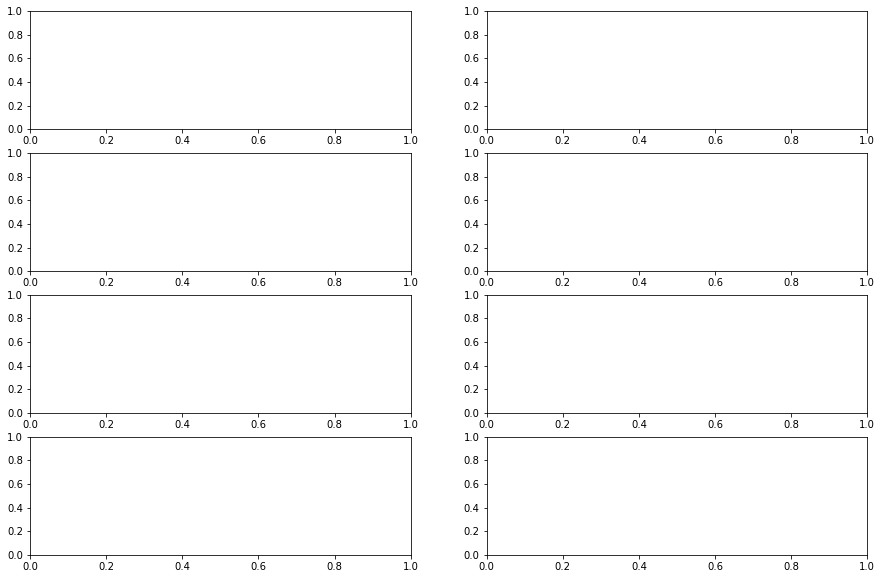

In [136]:
col_for_plotting = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI', 'EVI']

from sklearn.preprocessing import PowerTransformer, normalize, StandardScaler
data_agg_list = ['_median_indices']

# col_for_plotting = ['Blue']
# col_for_plotting = ['Green']
# col_for_plotting = ['Red']

for d_type in data_agg_list:
    for col in col_for_plotting:
        fields = len(field_year_dict_yield.keys())
        rows = math.ceil(fields/2)
        
        fig, ax = plt.subplots(rows,2, figsize=(15,10))
        plots = ax.flatten()
        n = 0
        # TODO: Fix the x ticks
        

        for field_sample, dates in sorted_field_year_dict_yield.items():
            x_labels = []
            # Adding required data to a temp dataframe
            temp_df = pd.DataFrame()
            for date in dates:
                date_str = date.strftime('%d%m%y')
                field_df = field_sample[:-5]+'_'+date_str+d_type
                temp_df[date] = locals()[field_df][col]
                x_label = date.strftime('%d-%m-%y')+':'+str(len(locals()[field_df][col]))
                
                x_labels.append(x_label)
                x_labels= list(set(x_labels))
            # Transform the df
#             pt = PowerTransformer(method='box-cox', standardize=False)
            pt = PowerTransformer(method='yeo-johnson', standardize=False)

            temp_arr = pt.fit_transform(temp_df)
            temp_df = pd.DataFrame(temp_arr)
            
            # Adding field plot to the subplots
            num_of_fields = len(field_year_dict_yield.keys())
            
            text = "Grain Yield"
            ax_n = plots[n]
            
            temp_df.boxplot(ax=ax_n)
            ax_n.set_xticklabels(x_labels, rotation=-35)
            ax_n.set_title(field_sample+'_'+col+d_type[:-5]+'_yeo-johnson')
            
#             # Printing the grain yield in plot of the fiels_sample for reference
#             ax_n.text(0.85, 1.05, text, ha='center', va='top', weight='bold', color='blue', transform=ax_n.transAxes)
            n+=1
        plt.tight_layout()



### Box-Cox Transformation

In [ ]:
col_for_plotting = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI', 'EVI']

from sklearn.preprocessing import PowerTransformer, normalize, StandardScaler
data_agg_list = ['_median_indices']

# col_for_plotting = ['Blue']
# col_for_plotting = ['Green']
# col_for_plotting = ['Red']

for d_type in data_agg_list:
    for col in col_for_plotting:
        fields = len(field_year_dict_yield.keys())
        rows = math.ceil(fields/2)
        
        fig, ax = plt.subplots(rows,2, figsize=(15,10))
        plots = ax.flatten()
        n = 0
        # TODO: Fix the x ticks
        for field_sample, dates in sorted_field_year_dict_yield.items():
            
            # Adding required data to a temp dataframe
            temp_df = pd.DataFrame()
            for date in dates:
                date_str = date.strftime('%d%m%y')
                field_df = field_sample[:-5]+'_'+date_str+d_type
                temp_df[date] = locals()[field_df][col]
            x_labels = temp_df.columns.tolist()

            # Transform the df
#             pt = PowerTransformer(method='box-cox', standardize=False)
            pt = PowerTransformer(method='box-cox', standardize=False)

            # Taking absolute values of the dataframe(avoiding negative values)
            temp_arr = pt.fit_transform(temp_df.abs())
            temp_df = pd.DataFrame(temp_arr)
            
            # Adding field plot to the subplots
            num_of_fields = len(field_year_dict_yield.keys())
            
            text = "Grain Yield"
            ax_n = plots[n]

            temp_df.boxplot(ax=ax_n)
            ax_n.set_xticklabels(x_labels, rotation=90)
            ax_n.set_title(field_sample+'_'+col+d_type[:-5]+'_box-cox')
            
#             # Printing the grain yield in plot of the fiels_sample for reference
#             ax_n.text(0.85, 1.05, text, ha='center', va='top', weight='bold', color='blue', transform=ax_n.transAxes)
            n+=1
        plt.tight_layout()



### ToDo: Identify Dates and index with problems

### Ecxclude the problematic data/dates
or
### Take average values where the problematic data is

Take average of data for date 20200708 and 20200624  
Masbasis  
Cleanup  
Remove dates which have drop  

## ToDo: Remove outliers

### Find AUC for all dates of one field
See if it covers tha gaps under the dates,i.e.

Since data points are different  
Flying time is different  
Cover the gaps between the dates  

Since the data collection is not uniform throughout the year so AUC will give a single value instead of multiple values for one field year which will be representative of all the dates 

#### Option 1: Use Scipy

In [137]:
import scipy
scipy.__version__

'1.6.1'

In [138]:
from scipy import integrate
from scipy.integrate import simps

In [139]:
from scipy.integrate import simpson

In [140]:
x = np.arange(0, 10)
y = np.arange(0, 10)


In [141]:
# integrate.simpson(y, x)
integrate.simps(y, x)

40.5

In [142]:
y = np.power(x, 3)
y

array([  0,   1,   8,  27,  64, 125, 216, 343, 512, 729], dtype=int32)

In [143]:
integrate.simpson(y, x)
# integrate.simps(y, x)


1642.5

In [144]:
integrate.quad(lambda x: x**3, 0, 9)[0]

1640.25

In [145]:
integrate.simpson(y, x, even='first')
# integrate.simps(y, x, even='first')

1644.5

#### Option 2

In [146]:
data
# plot: Plot ID
# x: Number of days after sowing or actual date
# y: Value of the index


'C:\\\\Users\\\\fahad\\MegaSync\\NMBU\\Master Thesis\\Data\\Feb2021\\2020 Vollebekk Graminor\\2020TGraminor-Vollebekk-res.xlsx'

In [147]:
# x: Days from sowing to data collection
# May 5 2019 Masbasis and Graminor
# Robot: 

data={'plot':['1','1','2','2','3','3'],'x':['5','6','7','8','9','10'],'y':['0.9','0.8','0.7','0.6','0.5','0.4'] }

ACC=[]
A=pd.DataFrame(data, columns=['plot','x','y'])
AA=0

for item in range(len(A)-1):
    if A['plot'][item]== A['plot'][item+1]:
        Ans=(float((A['y'][item]))+float((A['y'][item+1])))*((float((A['x'][item+1]))-float((A['x'][item]))))/2
        AA+=Ans
        print(AA)
        ACC.append(AA)

0.8500000000000001
1.5
1.95


### Alternative

In [148]:
df1=Data.set_index(['Plot'])
ACC=[]

for item in Numbers_final:
    df2=df1[df1.index==item]
    df2=df2.filter(['Blue', 'Green', 'Red', 'RedEdge', 'NIR','NDVI', 'MTCI', 'EVI', 'DVI', 'RVI', 'VARI', 'EXG', 'EXGR', 'GLI', 'GNDVI', 'GVI','Time','timepoint'], axis=1)
    df2=df2.sort_values(by='timepoint')
    df3=df2.reset_index()

AA=0
for j in range(0,3):
    Ans=(float((df3['GVI'][j]))+float((df3['GVI'][j+1])))*((float((df3['timepoint'][j+1]))-float((df3['timepoint'][j]))))/2
    AA+=Ans

    print(AA)
    ACC.append(AA)



DA=pd.DataFrame(ACC)
DD=pd.DataFrame(Numbers_final)
DDA=pd.concat([DD, DA], axis=1)
DDA.to_excel('Staur_Accumulative_GVI_2019.xlsx')

NameError: name 'Data' is not defined

### Time series data vs the AUC

# ToDo: Model Training


Make model for one year at a time and try to predict yield of another field  

TODO: Train on Masbasis 2019 an 2020  
Test on Staur  

Use data until august for yield prediction since it is most relavant  
Use all data for predicting date to maturity  

Data Collection:  
Data collection usually starts after heading  
2019 has the data before hading as well. To use that, dont use dates before heading  

NDVI is resistant to shadows  

DAT390 Report: Do the report with Robot Data only  

TODO: Use AUC for each index for prediction  

TODO:   
Time series data vs the AUC  